In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

import pandas as pd

# 使用相对路径读取CSV文件
try:
    train_data = pd.read_csv('data/train.csv')
    print(train_data.head())
except FileNotFoundError:
    print("文件未找到")
except Exception as e:
    print(f"发生未知错误: {str(e)}")

try:
    test_data = pd.read_csv('data/test.csv')
    print(test_data.head())
except FileNotFoundError:
    print("文件未找到")
except Exception as e:
    print(f"发生未知错误: {str(e)}")



   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   
4   4  7415 O Donovan Rd   1175000.0   

                                             Summary          Type  \
0  540 Pine Ln, Los Altos, CA 94022 is a single f...  SingleFamily   
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  SingleFamily   
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...  SingleFamily   
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  SingleFamily   
4  Beautiful 200 acre ranch land with several pas...    VacantLand   

   Year built                                       Heating  \
0      1969.0  Heating - 2+ Zones, Central Forced Air - Gas   
1      1926.0                                   Combination   
2      1958.0                                    Forced air   
3      1947.0                                       Central   
4         NaN          

In [5]:
print(train_data.iloc[:, :5]) # 看着感觉有很多不知所谓的项

          Id                   Address  Sold Price  \
0          0               540 Pine Ln   3825000.0   
1          1            1727 W 67th St    505000.0   
2          2            28093 Pine Ave    140000.0   
3          3         10750 Braddock Dr   1775000.0   
4          4         7415 O Donovan Rd   1175000.0   
...      ...                       ...         ...   
47434  47434        2409 Florence Blvd    159000.0   
47435  47435  1085 Tasman Dr SPACE 818    255000.0   
47436  47436   1338 N Orange Grove Ave   2300000.0   
47437  47437         9996 Fan Shell Ln    500000.0   
47438  47438           4552 Howard Ave    760000.0   

                                                 Summary                Type  
0      540 Pine Ln, Los Altos, CA 94022 is a single f...        SingleFamily  
1      HURRY, HURRY.......Great house 3 bed and 2 bat...        SingleFamily  
2      'THE PERFECT CABIN TO FLIP!  Strawberry deligh...        SingleFamily  
3      Rare 2-story Gated 5 bedroom

In [7]:
print(train_data.shape)

(47439, 41)


In [2]:
all_features = pd.concat((train_data.iloc[:, 1:-2], test_data.iloc[:, 1:-2]))
all_features.dtypes
print(all_features.dtypes != 'object')

Address                        False
Sold Price                      True
Summary                        False
Type                           False
Year built                      True
Heating                        False
Cooling                        False
Parking                        False
Lot                             True
Bedrooms                       False
Bathrooms                       True
Full bathrooms                  True
Total interior livable area     True
Total spaces                    True
Garage spaces                   True
Region                         False
Elementary School              False
Elementary School Score         True
Elementary School Distance      True
Middle School                  False
Middle School Score             True
Middle School Distance          True
High School                    False
High School Score               True
High School Distance            True
Flooring                       False
Heating features               False
C

In [3]:
def get_str_length(series):
    return series.fillna('').apply(lambda x: len(str(x)))

# 计算各列字符串长度
all_features['Heating'] = get_str_length(all_features['Heating'])
all_features['Cooling'] = get_str_length(all_features['Cooling'])
all_features['Parking'] = get_str_length(all_features['Parking'])

In [4]:
all_features['Bedrooms'] = all_features['Bedrooms'].apply(
    lambda x: (str(x).count(',') + 1) if not str(x).replace(',', '').isdigit() else int(x)
)
all_features['Appliances included'] = all_features['Appliances included'].apply(
    lambda x: (str(x).count(',') + 1) if not str(x).replace(',', '').isdigit() else int(x)
)

In [5]:
all_features = all_features.drop(['Laundry features', 'Cooling features', 'Heating features', 'Flooring', 'Parking features'], axis=1)
all_features = all_features.drop(['City', 'High School', 'Middle School', 'Elementary School'], axis=1)
all_features = all_features.drop(['Summary', 'Address'], axis=1)

In [6]:
all_features["Last Sold On"] = pd.to_datetime(
    all_features["Last Sold On"],
    errors="coerce"  # 无效日期转为空值（如 "Unknown" 会变成 NaT）
).dt.year
year_d = pd.to_datetime(
    all_features["Listed On"],
    errors="coerce"  # 无效日期转为空值（如 "Unknown" 会变成 NaT）
).dt.year - 2019
mouth_d = all_features["Listed On"] =pd.to_datetime(
    all_features["Listed On"],
    errors="coerce"  # 无效日期转为空值（如 "Unknown" 会变成 NaT）
).dt.month
all_features["Listed On"] = year_d*12 + mouth_d
print(all_features.shape)
print(all_features.iloc[0:4, [24]])

(79065, 27)
   Listed Price
0     4198000.0
1      525000.0
2      180000.0
3     1895000.0


In [7]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(79065, 1459)

In [8]:
# 标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [17]:
print(train_data.shape[0])

47439


In [26]:
print(train_data)

          Id                   Address  Sold Price  \
0          0               540 Pine Ln   3825000.0   
1          1            1727 W 67th St    505000.0   
2          2            28093 Pine Ave    140000.0   
3          3         10750 Braddock Dr   1775000.0   
4          4         7415 O Donovan Rd   1175000.0   
...      ...                       ...         ...   
47434  47434        2409 Florence Blvd    159000.0   
47435  47435  1085 Tasman Dr SPACE 818    255000.0   
47436  47436   1338 N Orange Grove Ave   2300000.0   
47437  47437         9996 Fan Shell Ln    500000.0   
47438  47438           4552 Howard Ave    760000.0   

                                                 Summary                Type  \
0      540 Pine Ln, Los Altos, CA 94022 is a single f...        SingleFamily   
1      HURRY, HURRY.......Great house 3 bed and 2 bat...        SingleFamily   
2      'THE PERFECT CABIN TO FLIP!  Strawberry deligh...        SingleFamily   
3      Rare 2-story Gated 5 bed

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(
    train_data['Sold Price'].values.reshape(-1, 1),  # 提取列并转为二维数组
    dtype=torch.float32
)

In [10]:
# 均方误差损失函数
loss = nn.MSELoss()
# 确定输入层的神经元数量: train_features.shape[1] 是特征的数量（即每行数据的列数）
in_features = train_features.shape[1]

# 创建一个简单的单层神经网络（线性回归模型）
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 128),  # 输入层 → 隐藏层1（宽度128）
        nn.ReLU(),                    # 激活函数引入非线性[1,4](@ref)
        nn.Linear(128, 64),           # 隐藏层1 → 隐藏层2（宽度64）
        nn.Tanh(),                    # 可选Tanh/Sigmoid等其他激活函数
        nn.Linear(64, 1)              # 输出层（回归任务保持1个神经元）
    )
    return net

In [11]:
# 通过对预测值和标签取对数，将优化目标从绝对误差转换为相对误差，使得模型更关注预测值与真实值的比例关系，而非绝对数值差异
# 这种设计在处理量纲差异大的数据时尤为重要，能更公平地优化所有样本
def log_rmse(net, features, labels):
    # 将预测值限制在 [1,+∞) 范围内，确保对数操作有效(房价肯定大于0)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [12]:
# 训练函数
# net：待训练的神经网络模型。train_features/train_labels：训练集特征和标签。
# test_features/test_labels：测试集特征和标签（可选，用于监控泛化性能）。
# num_epochs：训练轮次。learning_rate：学习率。
# weight_decay：权重衰减（L2正则化系数），用于防止过拟合。batch_size：批处理大小。
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 初始化训练与测试损失列表: 记录每轮训练后的训练集和测试集损失
    # 用于监控模型在训练和验证数据上的表现，判断是否过拟合或欠拟合
    train_ls, test_ls = [], []
    # 将训练数据转换为 DataLoader，每次迭代返回一个批次的 (X, y)，大小为 batch_size
    train_iter = d2l.load_array((train_features, train_labels), batch_size) #传入特征和标签, 将数据封装为 TensorDataset 和 DataLoader
    # 定义优化器（Adam）, 并输入待优化的模型参数、学习率、梯度衰减系数
    # 目的：调整模型参数，优化模型
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    # 训练循环
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #梯度清零：optimizer.zero_grad() 清除上一轮的梯度，避免累积
            optimizer.zero_grad()
            # ​前向传播：net(X) 计算模型预测值
            # ​损失计算：loss(net(X), y) 计算预测值与标签的损失
            l = loss(net(X), y)
            # ​反向传播：l.backward() 计算梯度
            l.backward()
            # ​参数更新：optimizer.step() 根据梯度更新模型参数(利用上文的Adam)
            optimizer.step()
        # 训练损失记录：使用 log_rmse 计算当前模型在训练集上的对数均方根误差
        train_ls.append(log_rmse(net, train_features, train_labels))
        # ​测试损失记录：如果提供测试集，计算模型在测试集上的误差
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [13]:
# k折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.875510, valid log rmse 0.794669
fold 2, train log rmse 0.865926, valid log rmse 0.823139
fold 3, train log rmse 0.864903, valid log rmse 0.846746
fold 4, train log rmse 0.866605, valid log rmse 0.878349
fold 5, train log rmse 0.849517, valid log rmse 0.980603
5-折验证: 平均训练log rmse: 0.864492, 平均验证log rmse: 0.864701


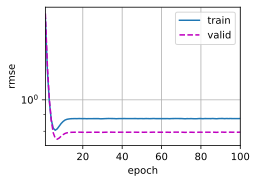

In [15]:
# 模型选择: 设定超参数
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.864764


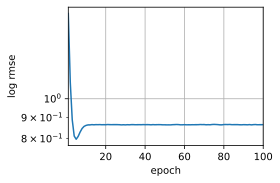

In [17]:
# 训练并生成结果文件(用于提交结果)
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)